# Plot an amplitude image log and segment it using custom or automatized (Otsu's) thresholds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os

import numpy as np

In [2]:
def Image_plot(image_df):
    # Plots AMP image using appropriate colormap
    
    fig, ax = plt.subplots(figsize=(4, 9), dpi=100)  # Create a figure containing a single axes.
    ax.ticklabel_format(useOffset = False)
    ax.invert_yaxis()
    ax.set_xlabel('AMP Image')   
              
    ax.imshow(image_df,
              extent=[0, len(image_df.columns), min(image_df.index), max(image_df.index)],
              cmap='afmhot',
              vmin= np.mean(image_df.values) - np.std(image_df.values),
              vmax= np.mean(image_df.values) + np.std(image_df.values),
              aspect='auto'
              )
            
    plt.ticklabel_format(useOffset=False)
    plt.show()

In [3]:
def concat_IMG_data(well_id, data_path):
    # Due to file size limitations, the original AMP '.csv' file
    # has been split into several sub-files.
    # The concat_IMG_data() function aims to concatenate
    # the data back into a single data object.
    #
    # concat_IMG_data() returns a Pandas dataframe whose
    # index column is DEPTH information and columns are
    # azimuthal coordinates of the AMP log.
    
    # Name of the initial '00' file
    initial_file = well_id + "_AMP00.csv"

    # Read the the initial file to capture header information
    initial_file_path = os.path.join(data_path, initial_file)
    image_df = pd.read_csv(initial_file_path,sep = ';',
                           index_col=0,
                           na_values = -9999,na_filter = True,
                           decimal = ',',
                           skip_blank_lines = True).dropna()

    # Read and aggregate data from the remaining files sequentially
    for file in os.listdir(data_path):
        if file.startswith(well_id) and file != initial_file:
            file_path = os.path.join(data_path, file)
            df_temp = pd.read_csv(file_path,sep = ';',
                                  header=None,index_col = 0,
                                  na_values = -9999, na_filter = True,
                                  decimal = ',', skip_blank_lines = True,
                                  dtype=np.float32
                                 ).dropna()
            
            # Adjust tem df's header to match image header
            df_temp.columns=image_df.columns
            
            # Concat dfs
            image_df = pd.concat([image_df, df_temp])
    return image_df

## Import image data from CSV file

In [4]:
# Directory where the AMP image data files are located
img_data_path = "..\dataset\img"

In [5]:
# Well identifier
well_identifier = "antilope25"

In [6]:
# Whole image data
img_data = concat_IMG_data(well_identifier,img_data_path)

In [7]:
img_data = img_data.iloc[img_data.index > 2065.52]  # Deleting spurious values at the top of the image file
img_data = img_data.iloc[img_data.index <= 2277.10]     # Interest limit

## Plot an image slice

In [8]:
slice_img_df = img_data.iloc[600:1200]   #User defined data slice

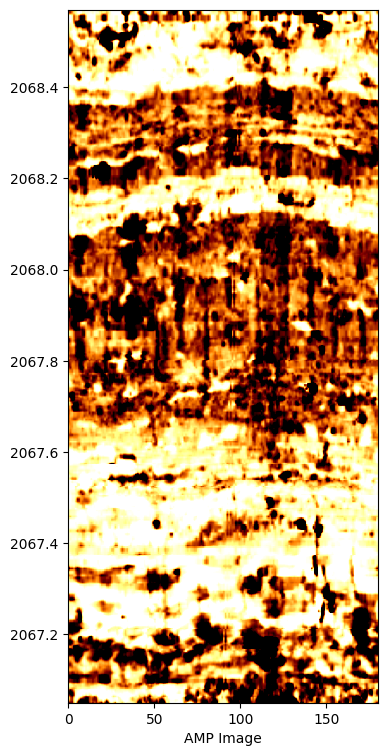

In [9]:
Image_plot(slice_img_df)

## Plot AMP (dB) Histogram according to range values

Plot histogram and segment image according the definitions present in [Menezes de Jesus et al, 2016](https://onepetro.org/petrophysics/article/57/06/620/171448/Permeability-Estimation-Using-Ultrasonic-Borehole).

In [10]:
# Flatten amplitude values
data = img_data.values.flatten('F')

In [11]:
# User definded thresholds
threshold = [26, 34, 37]

# User definded range
range_dB = np.array((-20, 40))

# User definded number of bins in histogram
n_bins = 50

# range for every bin
delta_bin = np.abs((range_dB[1] - range_dB[0]))/n_bins

# Compute the number of bins per class based on 'delta_bin'
range_bins = np.array((int((threshold[0] - range_dB[0])//delta_bin),
                       int((threshold[1] - range_dB[0])//delta_bin),
                       int((threshold[2] - range_dB[0])//delta_bin)))

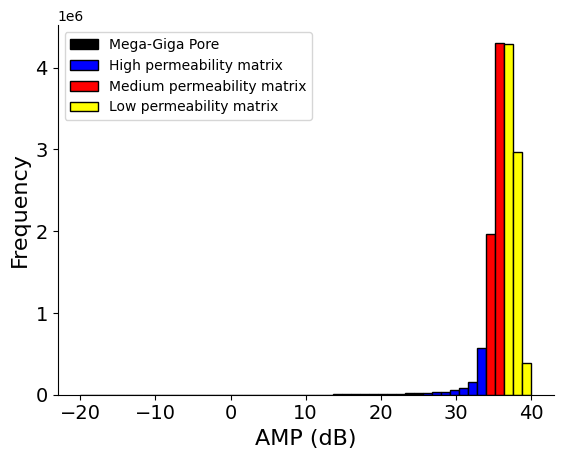

In [12]:
from matplotlib.patches import Rectangle

N, bins, patches = plt.hist(data, bins=n_bins, ec="k", range=(range_dB[0], range_dB[1]))

mgp = (0.0, 0.0, 0.0, 1.0)    # for Mega-Giga Pore values
hpm = (0.0, 0.0, 1.0, 1.0)    # for High-Permeability matrix values
mpm = (1.0, 0.0, 0.0, 1.0)    # for Medium-Permeability matrix values
lpm = (1.0, 1.0, 0.0, 1.0)    # for Low-Permeability matrix values


for i in range(0,range_bins[0]):
    patches[i].set_facecolor(mgp)
    
for i in range(range_bins[0],range_bins[1]):
    patches[i].set_facecolor(hpm)
    
for i in range(range_bins[1],range_bins[2]):
    patches[i].set_facecolor(mpm)
    
for i in range(range_bins[2],n_bins):
    patches[i].set_facecolor(lpm)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [mgp, hpm, mpm, lpm]]
labels= ['Mega-Giga Pore', 'High permeability matrix', 'Medium permeability matrix', 'Low permeability matrix']
plt.legend(handles, labels)

plt.xlabel('AMP (dB)', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()

## Segment after histogram categories

In [13]:
amp_array = img_data.values
amp_segment = np.zeros(amp_array.shape)

for i, img_row in enumerate(amp_array):
    for j, amp_value in enumerate(img_row):
        
        if amp_value <= threshold[0]:
            amp_segment[i][j] = 3
        elif amp_value <= threshold[1]:
            amp_segment[i][j] = 2
        elif amp_value <= threshold[2]:
            amp_segment[i][j] = 1
        else:
            amp_segment[i][j] = 0

In [14]:
seg_df = pd.DataFrame(amp_segment)

seg_df.insert(0, column = 'DEPTH', value = img_data.index)
seg_df.set_index('DEPTH', inplace=True)

In [15]:
seg_df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
DEPTH,,,,,,,,,,,,,,,,,,,,,
2065.530000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2065.530000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2065.530000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2065.530000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2065.540000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277.080078,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2277.080078,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2277.090088,3.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [16]:
# Creat custom colormaps to plot segmentations
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['yellow', 'red', 'blue', 'black'])
custom_cmap_r = ListedColormap(['black', 'blue', 'red', 'yellow'])

In [17]:
slice_seg_df = seg_df.iloc[600:1200]

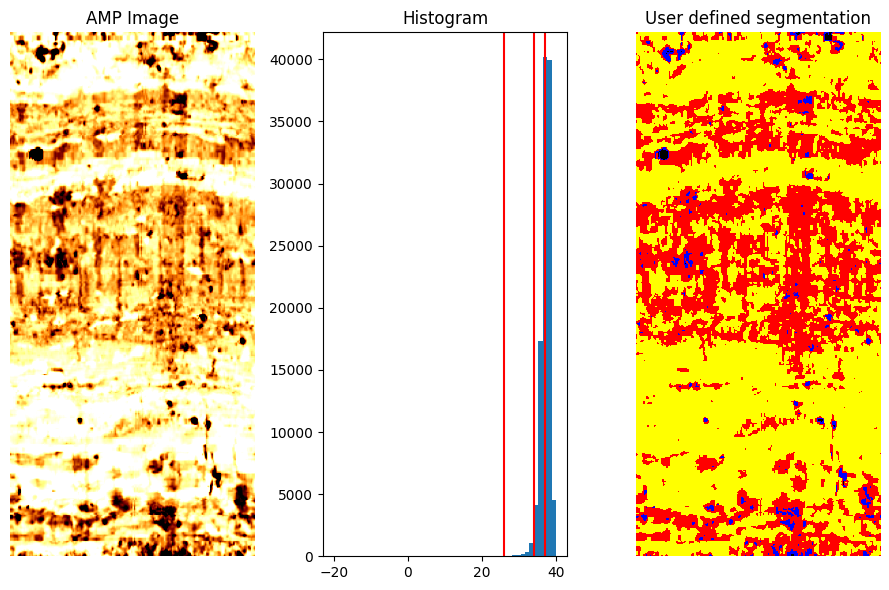

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,6), dpi=100)

# Plotting the original seg_df.
ax[0].imshow(slice_img_df, cmap='afmhot',aspect='auto',vmin= np.mean(img_data.values) - np.std(img_data.values),
              vmax= np.mean(img_data.values) + np.std(img_data.values))
ax[0].set_title('AMP Image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(slice_img_df.values.flatten('F'), bins = bins)
ax[1].set_title('Histogram')
for thresh in threshold:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(slice_seg_df, cmap=custom_cmap, aspect='auto')
ax[2].set_title('User defined segmentation')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

## Otsu (multi) thresholding

Otsu's method [1](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html#sphx-glr-auto-examples-segmentation-plot-multiotsu-py) allows to automatically determining the thresholds after an image's predetermined number of classes according to its pixel's intensity levels.

In [19]:
from skimage.filters import threshold_otsu, threshold_multiotsu

C:\Users\cj78\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [20]:
image = slice_img_df.values

In [21]:
otsu_thresholds = threshold_multiotsu(img_data.values, classes=4)
#binary_otsu = ndvi > thresh

print(otsu_thresholds)

[27.27708416 34.57956835 36.6659924 ]


In [22]:
# Using the threshold values for the 4 classes
regions = np.digitize(image, bins=otsu_thresholds)

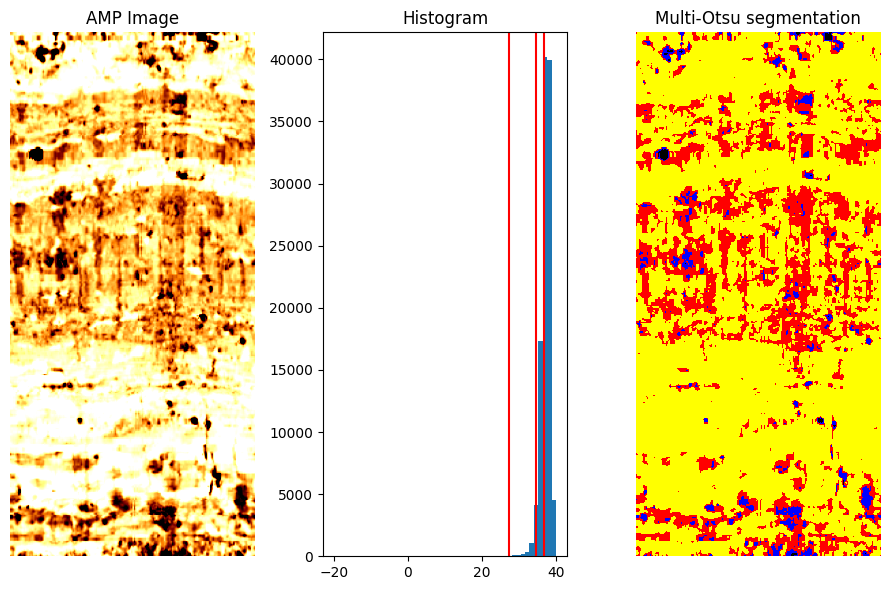

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,6), dpi=100)

# Plotting the original seg_df.
ax[0].imshow(image, cmap='afmhot',aspect='auto',vmin= np.mean(img_data.values) - np.std(img_data.values),
              vmax= np.mean(img_data.values) + np.std(img_data.values))
ax[0].set_title('AMP Image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.flatten('F'), bins = bins)
ax[1].set_title('Histogram')
for thresh in otsu_thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap=custom_cmap_r, aspect='auto')
ax[2].set_title('Multi-Otsu segmentation')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [24]:
# Compute the number of bins per class based on 'delta_bin'
otsu_range_bins = np.array((int((otsu_thresholds[0] - range_dB[0])//delta_bin),
                            int((otsu_thresholds[1] - range_dB[0])//delta_bin),
                            int((otsu_thresholds[2] - range_dB[0])//delta_bin)))

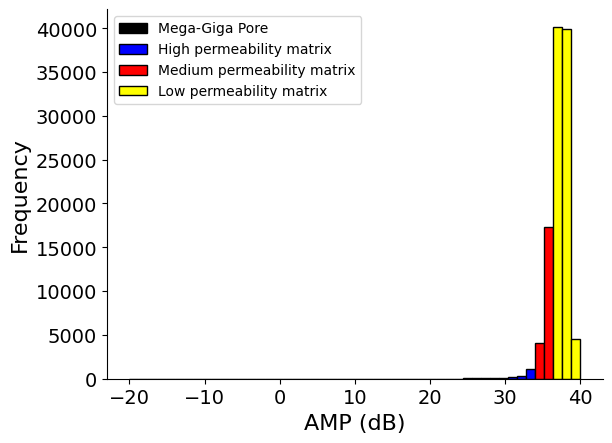

In [25]:
data = image.flatten('F')
N, bins, patches = plt.hist(data, bins = n_bins, ec="k", range = (range_dB[0], range_dB[1]))

mgp = (0.0, 0.0, 0.0, 1.0)
hpm = (0.0, 0.0, 1.0, 1.0)
mpm = (1.0, 0.0, 0.0, 1.0)
lpm = (1.0, 1.0, 0.0, 1.0)


for i in range(0,otsu_range_bins[0]):
    patches[i].set_facecolor(mgp)
    
for i in range(otsu_range_bins[0],otsu_range_bins[1]):
    patches[i].set_facecolor(hpm)
    
for i in range(otsu_range_bins[1],otsu_range_bins[2]):
    patches[i].set_facecolor(mpm)
    
for i in range(otsu_range_bins[2],n_bins):
    patches[i].set_facecolor(lpm)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [mgp, hpm, mpm, lpm]]
labels= ['Mega-Giga Pore', 'High permeability matrix', 'Medium permeability matrix', 'Low permeability matrix']
plt.legend(handles, labels)

plt.xlabel('AMP (dB)', fontsize=16)  
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.show()